# Example notebook for STM analysis with python
## Feature identification with SVD and KMeans
### Steven R. Schofield, June 2021

In [9]:
# The commands in this box are just things to make the notebook a little nicer, and to clear variables
# and make sure any module changes are reloaded.

# clear all variables 
get_ipython().magic('reset -f') 

# These "magic" commands ensure a module is reloaded if it has been changed
%load_ext autoreload
%autoreload 2

# This "magic" command ensures plot are displayed
%matplotlib inline

# This turns off the warnings that come in pycroscopy regarding future changes. 
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)  

# Make Notebook take up most of page width
from IPython.core.display import HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 99%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

/var/folders/_0/4qh22dfj6z9764qs2_6tddbr0000gp/T/ipykernel_245/1362413557.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Some pages relevant to the modules listed below. 
#
# https://nbviewer.jupyter.org/github/pycroscopy/papers/blob/master/HTML/EM/STEM/Image_Cleaning_Atom_Finding.html
#
# https://pycroscopy.github.io/pycroscopy/papers_conferences.html

In [11]:
# LOAD REQUIRED MODULES 

# General utilities, file io etc. 
import os
import sys

# File format
import h5py        # h5py file format

# For calculating time taken
from time import time

# Pycroscopy modules
import pycroscopy as px # Scientific analysis of nanoscale materials imaging data
import pyUSID as usid   # Framework for storing, visualizing, and processing Universal Spectroscopic and Imaging Data (USID)
import sidpy            # Supporting package for pyUSID utilities for storing and visualizing Spectroscopic and Imaging Data (USID)

# General image analysis (not pyscroscopy)
import spiepy                # Scanning Probe Image Enchanter using Python: is a Python library to improve automatic processing of SPM images.

# Math 
import numpy as np # The fundamental package for scientific computing with Python, particularly involving arrays

# Visualization:
import matplotlib.pyplot as plt

# For KMeans clustering
from sklearn.cluster import KMeans

# For Dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist 

# For motif selection
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import ImageGrid

In [12]:
nbStart = time()

In [14]:
# LOAD SRS module for loading Scienta Omicron data.

# get the path of this notebook.  I'm assuming my module and the data are in ../SRS and ../data...
current_path = os.getcwd()
sys.path.append('..')

# My module for using MTRX format data with pycroscopy.
import SRSML as spm

In [15]:
# Folder containing the data to be loaded

# Si(111):B
dataFilePath = "../data/MTRX/11-Jun-2014"
imgFileName='default_2014Jun11-163508_STM-STM_Spectroscopy--57_1.Z_mtrx'

# Si(111):B (smaller image)
dataFilePath = "../data/MTRX/15-Jun-2014" 
imgFileName='default_2014Jun15-190130_STM-STM_Spectroscopy--41_1.Z_mtrx'

# Ge(001):AsH3
dataFilePath = "../data/MTRX/5-Mar-2020"
imgFileName='default_2020Mar05-185936_STM-STM_Spectroscopy--9_38.Z_mtrx'

# Si(001):Bi 
dataFilePath = "../data/MTRX/06-Nov-2014" 
imgFileName='default_2014Nov06-155629_STM-STM_Spectroscopy--8_2.Z_mtrx'

# Si(001):Bi 
dataFilePath = "../data/MTRX/03-Dec-2014" 
imgFileName='default_2014Dec03-174559_STM-STM_Spectroscopy--33_1.Z_mtrx'

The current folder is: /Users/steven/academic/calc/Python/srs-ml/work-srs
Will attempt to open file: /Users/steven/academic/calc/Python/srs-ml/work-srs/../data/MTRX/03-Dec-2014/default_2014Dec03-174559_STM-STM_Spectroscopy--33_1.Z_mtrx
Saving H5USID file in directory ../data/H5USID
Name of h5USID file saved: ../data/H5USID/default_2014Dec03-174559_STM-STM_Spectroscopy--33_1.h5
Writing h5 file: 
../data/H5USID/default_2014Dec03-174559_STM-STM_Spectroscopy--33_1.h5


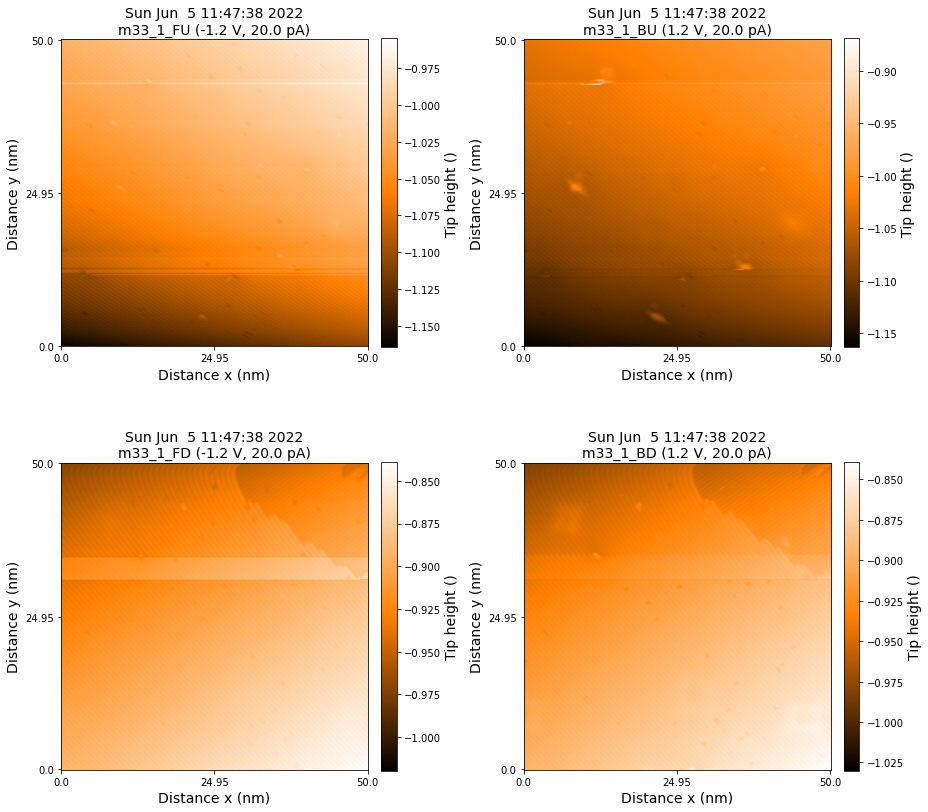

In [16]:
# Read the MTRX data, then write this to disk as h5USID format. 
h5OrigFileName = spm.MTRXtoh5USID(dataFilePath,imgFileName)
                              
# Display the plane subtracted data from the previous step.
spm.h5_plot_MTRXformat(h5OrigFileName)

In [17]:
# Get just one of the images, e.g., forward up
h5SingleImageFileName = spm.h5_manipulate(h5OrigFileName,selectone='BD')

Writing h5 file: 
../data/H5USID/default_2014Dec03-174559_STM-STM_Spectroscopy--33_1FU.h5


In [18]:
#spm.h5_plot_MTRXformat(h5SingleImageFileName)

In [19]:
# Get just one of the images, e.g., forward up
h5SingleImageBGFileName = spm.h5_manipulate(h5SingleImageFileName,background='mask')

Writing h5 file: 
../data/H5USID/default_2014Dec03-174559_STM-STM_Spectroscopy--33_1FUm.h5


In [11]:
# Display the plane subtracted FU data from the previous step.
#spm.h5_plot_MTRXformat(h5SingleImageBGFileName)

## Start data analysis

In [20]:
# Set color scheme for images
imageCmap = spiepy.NANOMAP
imageCmap = imageCmap = plt.cm.ocean

In [21]:
# open the h5USID file
h5File = h5py.File(h5SingleImageBGFileName, mode='r+')
# Get the image as numpy array and calculate its size
h5img = usid.hdf_utils.get_all_main(h5File)[-1]
#h5Pos = h5img.h5_pos_inds                         # grab position indices from the H5 file
imgRows, imgCols = h5img.pos_dim_sizes            # determine the image size:
print('\nThe original image has {} rows, {} columns, and therefore {} pixels.'.format(imgRows, imgCols, imgRows * imgCols))
figIMG, axesIMG = h5img.visualize(cmap=imageCmap,figsize=(14,7))

# If you get an error that the file is already open, please just delete the .h5 file and then re-run the box above to 
# recreate the file.  I haven't found a better way to do this...  It seems to happen because python thinks some other
# programme is using the file...


The original image has 500 rows, 500 columns, and therefore 250000 pixels.


AttributeError: can't set attribute

## Create the image windows from the full image

In [86]:
## Choose a window size and plot an example window.
winSize=25

# Initialise image window class on image main dataset
iw = px.processing.ImageWindow(h5img, max_RAM_mb=1024*4)

# Windowing the data
t0 = time()
#h5Windows = iw.do_windowing(win_x=winSize,win_y=winSize,save_plots=False,show_plots=False,win_fft='data+abs')
h5Windows = iw.do_windowing(win_x=winSize,win_y=winSize,save_plots=False,show_plots=False,win_fft=None)
print( 'Windowing took {} seconds.'.format(round(time()-t0, 2)))

Determining appropriate window size from image.
Optimal window size determined to be 25x25 pixels.
Writing attribute: machine_id with value: manganese-4.local
Attribute cleaned into: manganese-4.local
Writing attribute: timestamp with value: 2021_06_15-10_08_06
Attribute cleaned into: 2021_06_15-10_08_06
Writing attribute: win_x with value: 25
Attribute cleaned into: 25
Writing attribute: win_y with value: 25
Attribute cleaned into: 25
Writing attribute: win_step_x with value: 1
Attribute cleaned into: 1
Writing attribute: win_step_y with value: 1
Attribute cleaned into: 1
Writing attribute: image_x with value: 500
Attribute cleaned into: 500
Writing attribute: image_y with value: 500
Attribute cleaned into: 500
Writing attribute: psf_width with value: 2.1050894697113645
Attribute cleaned into: 2.1050894697113645
Writing attribute: fft_mode with value: data
Attribute cleaned into: data
Wrote all (simple) attributes to <class 'h5py._hl.group.Group'>: m33_1_BD-Windowing_000

Windowing Im

In [87]:
print('\nRaw data was of shape {} and the windows dataset is now of shape {}'.format(h5img.shape, h5Windows.shape))
print('Now each position (window) is descibed by a set of pixels')


Raw data was of shape (250000, 1) and the windows dataset is now of shape (226576, 625)
Now each position (window) is descibed by a set of pixels


## SVD

In [88]:
# I think the maximum numSVDComp is winSize * winSize. 
# However, the KMeans time scales with the number of components.  (WE are using numKMComp=numSVDComp)
# To give an idea, for a particular image these were the times for the full script to run:
#
# numSVDComp =  50 : 4.2 minutes
# numSVDComp = 100 : 4.6 minutes
# numSVDComp = 200 : 6.8 minutes
# numSVDComp = 300 : 9.5 minutes
# numSVDComp = 350 : 9.4 minutes
numSVDComp = 150


print('Number of SVD components is {}.'.format(numSVDComp))
    
h5processing = px.processing.SVD(h5Windows,num_components=numSVDComp)
h5SVD = h5processing.compute()

# Assigning U, sigma and V datasets to variables
h5U = h5SVD['U']
h5S = h5SVD['S']
h5V = h5SVD['V']

Number of SVD components is 150.
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file
Took 14.83 sec to compute randomized SVD


In [89]:
# Checking amount of components SVD gave us

print("There are a total of {} components (eigenvalues).".format(numSVDComp))
print('\nRaw data was of shape {} and the windows dataset is now of shape {}'.format(h5img.shape, h5Windows.shape))
print('Now each position (window) is descibed by a set of {} x {} = {} pixels'.format(winSize, winSize, winSize*winSize))

There are a total of 150 components (eigenvalues).

Raw data was of shape (250000, 1) and the windows dataset is now of shape (226576, 625)
Now each position (window) is descibed by a set of 25 x 25 = 625 pixels


In [90]:
# Grabbing position indices and num of rows and cols
h5Positions = iw.hdf.file[h5Windows.attrs['Position_Indices']]
# Use this to get the number of window rows and columns
numWindowRows = len(np.unique(h5Positions[:, 0]))
numWindowCols = len(np.unique(h5Positions[:, 1]))
print('Number of window rows and columns is {}, {}.'.format(numWindowRows, numWindowCols))
print('This should correspond to the original image size, {}, {}, minus the window size, plus 1, {}, {}, i.e., {}. {}.'.format(imgRows, imgCols, winSize, winSize,imgRows-winSize+1, imgCols-winSize+1))

Number of window rows and columns is 476, 476.
This should correspond to the original image size, 500, 500, minus the window size, plus 1, 25, 25, i.e., 476. 476.


In [91]:
h5Ureshaped = np.reshape(h5U, [numWindowRows, numWindowCols, -1])
h5Vreshaped = np.reshape(h5V, [numSVDComp, winSize, winSize])
h5Vreshaped = np.transpose(h5Vreshaped,(2,1,0))
# The U matrices are simple numpy arrays, but the V matrices can be "Image data" (or, I think 'FFT' or something, I'm not certain...)

print('The shape of the U matrix is {}'.format(h5Ureshaped.shape))
print('The shape of the S (sigma) matrix is {}'.format(h5S.shape))
print('The shape of the V matrix is {}'.format(h5Vreshaped.shape))


The shape of the U matrix is (476, 476, 150)
The shape of the S (sigma) matrix is (150,)
The shape of the V matrix is (25, 25, 150)


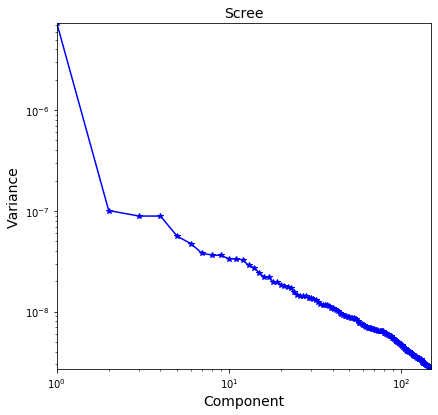

In [92]:
# Plotting log-log plot of sigma values against num of components
figS, axS = usid.plot_utils.plot_scree(h5S[()]);

## Atom Finding
#### We will attempt to find the positions and the identities of atoms in the image now

### Perform clustering on the dataset
#### Clustering divides data into k clusters such that the variance within each cluster is minimized. Here, we will be performing k-means clustering on a set of components in the U matrix from SVD. We want a large enough number of clusters so that K-means identifies fine nuances in the data. At the same time, we want to minimize computational time by reducing the number of clusters. We recommend 32 - 64 clusters.

## K mean clustering

In [93]:
# K-Means clustering on the U dataset. Choosing larger number of clusters to overcluster

# Number of features of U to use
numKMComp = numSVDComp

# Number of clusters for K-Means
numKMClusters = 50

estimator = px.processing.Cluster(h5U, KMeans(n_clusters=numKMClusters), num_comps=numKMComp)

if estimator.duplicate_h5_groups==[]:
    t0 = time()
    h5Kmeans = estimator.test()
    print('kMeans took {} seconds.'.format(round(time()-t0, 2)))
else:
    h5Kmeans = estimator.duplicate_h5_groups[-1]
    print( 'Using existing results.') 
    

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file
Performing clustering on /Topography_000/Backward_Down_000/m33_1_BD-Windowing_000/Image_Windows-SVD_000/U.
Took 5.03 mins to compute KMeans
Calculated the Mean Response of each cluster.
Took 30.51 sec to calculate mean response per cluster
kMeans took 332.55 seconds.


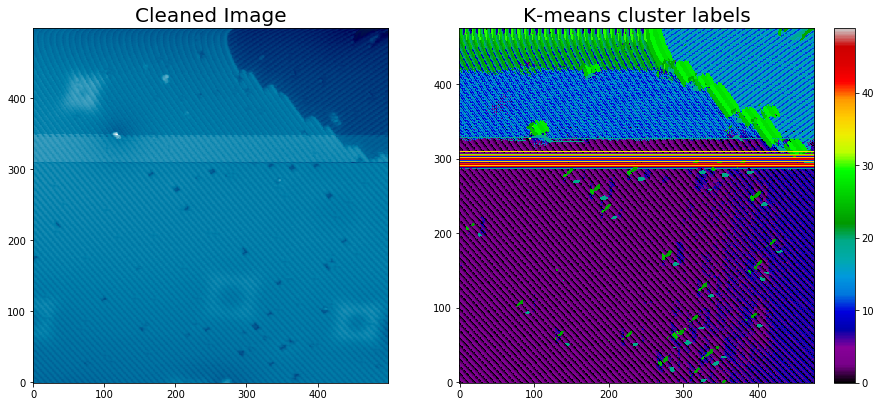

In [94]:
# Show K Means cluster labels

# Get original image
imgNp = h5img.get_n_dim_form().squeeze()

# Plot cluster results Get the labels dataset
labelsMat = np.reshape(h5Kmeans[0], [numWindowRows, numWindowCols])

# colormap for labels image
labelsCmap = plt.cm.nipy_spectral
#labelsCmap = plt.cm.gist_ncar
#labelsCmap = plt.cm.gnuplot2
#labelsCmap = plt.cm.seismic
#labelsCmap = plt.cm.rainbow
#labelsCmap = plt.cm.ocean
#labelsCmap = plt.cm.hsv
#labelsCmap = plt.cm.RdBu
#labelsCmap = plt.cm.jet

figCL, axesCL = plt.subplots(ncols=2, figsize=(14,7))
_ = axesCL[0].imshow(imgNp,cmap=imageCmap, origin='lower')
_ = axesCL[0].set_title('Cleaned Image', fontsize=20)
imgLabels = axesCL[1].imshow(labelsMat, aspect=1, interpolation='none',cmap=labelsCmap, origin='lower')
_ = axesCL[1].set_title('K-means cluster labels', fontsize=20);

# Add colour bar for labels image
cbarAxes = figCL.add_axes([0.92, 0.15, 0.02, 0.705])
_ = figCL.colorbar(imgLabels, cax=cbarAxes)

In [55]:
nbFinish = time()
print( 'Notebook took {} minutes.'.format(round((nbFinish - nbStart)/60, 2)))

Notebook took 10.68 minutes.


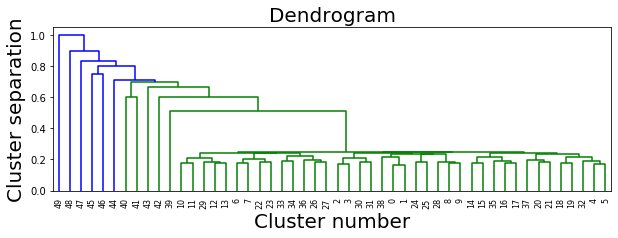

In [56]:
# Plot Dendrogram

# Get the distance between cluster means 
# distance_mat = pdist(h5_kmeans['Mean_Response'][()]) 
distanceMat = pdist(h5Kmeans[1]) 
 
#get hierachical pairings of clusters 
linkagePairing = linkage(distanceMat,'weighted') 

# Normalize the pairwise distance with the maximum distance
linkagePairing[:,2] = linkagePairing[:,2]/max(linkagePairing[:,2]) 

# Visualize dendrogram
fig = plt.figure(figsize=(10,3)) 
retval = dendrogram(linkagePairing, count_sort=True, 
           distance_sort=True, leaf_rotation=90) 
_ = fig.axes[0].set_title('Dendrogram', fontsize=20) 
_ = fig.axes[0].set_xlabel('Cluster number', fontsize=20) 
_ = fig.axes[0].set_ylabel('Cluster separation', fontsize=20)
# px.plot_utils.set_tick_font_size(fig.axes[0], 12)

## Select motifs

In [57]:
# Function to move the zoomed area box position on the main image
def moveZoomBox(coarse_row, coarse_col, fine_row, fine_col):
    row = coarse_row + fine_row
    col = coarse_col + fine_col
    mainVertLine.set_xdata((col, col))
    mainHorzLine.set_ydata((row, row))
    currentCenter[0] = row
    currentCenter[1] = col
    motifBox.set_x(col - halfWindow)
    motifBox.set_y(row - halfWindow)
    indices = (slice(row - halfWindow, row + halfWindow), 
               slice(col - halfWindow, col + halfWindow))
    imgZoom.set_data(croppedImg[indices])
    #img_zoom.set_clim(vmin=np.min(croppedCleanImg), vmax=np.max(croppedCleanImg))
    display(figCM)
    
# Function to select the motif when the button is pressed
def addMotif(butt):
    print("Setting motif with coordinates ({}, {})".format(currentCenter[0], currentCenter[1]))
    axesCM[0].add_patch(patches.Rectangle((currentCenter[1] - int(0.5*motifWinSize), 
                                           currentCenter[0] - int(0.5*motifWinSize)),
                                          motifWinSize, motifWinSize, fill=False,
                                         color='w', linewidth=2))
    motifWinCenters.append((currentCenter[0], currentCenter[1]))

In [58]:
# Duplicate imgNp with a half a window border cropped on all sides
halfWindow = int(winSize*0.5)
croppedImg = imgNp[halfWindow:-halfWindow + 1, halfWindow:-halfWindow + 1] 

# Define the size of the motif window
motifWinSize = winSize

# Initial position of the zoomed area cursor
currentCenter = [int(0.5*croppedImg.shape[0]), int(0.5*croppedImg.shape[1])]

# Set contrast for image
colorBarLim = [np.min(croppedImg),np.max(croppedImg)]

# 
figCM, axesCM = plt.subplots(ncols=2, figsize=(20,10))
_ = axesCM[0].clear()
_ = axesCM[0].imshow(croppedImg,cmap=imageCmap,clim=colorBarLim)
_ = axesCM[0].set_title('Image', fontsize=16)

# Add box select annotation to image 
mainVertLine = axesCM[0].axvline(x=currentCenter[1], color='w')
mainHorzLine = axesCM[0].axhline(y=currentCenter[0], color='w')
motifBox = axesCM[0].add_patch(patches.Rectangle((currentCenter[1] - halfWindow, currentCenter[0] - halfWindow),
                                          motifWinSize, motifWinSize, fill=False, color='w', linewidth=2))

#
indices = (slice(currentCenter[0] - halfWindow, currentCenter[0] + halfWindow), 
           slice(currentCenter[1] - halfWindow, currentCenter[1] + halfWindow))

# Create zoomed area image
imgZoom = axesCM[1].imshow(croppedImg[indices],cmap=imageCmap, clim=colorBarLim)
_ = axesCM[1].axvline(x=halfWindow, color='w')
_ = axesCM[1].axhline(y=halfWindow, color='w')
_ = axesCM[1].set_title('Currently selected area', fontsize=16)

# We don't want matplotlib to show the figure since it will be redrawn with the widget control and otherwise we end up with two figure panels
plt.close()

# initialise the motif list
motifWinCenters = list()

# Add a button to set the currently selected area as a motif
addMotifButton = widgets.Button(description="Set as motif")
display(addMotifButton)

# Define action for button
addMotifButton.on_click(addMotif)

# Add sliders to move the zoomed region
widgets.interact(moveZoomBox, coarse_row=(motifWinSize, croppedImg.shape[0] - motifWinSize, 1), 
                 coarse_col=(motifWinSize, croppedImg.shape[1] - motifWinSize, 1),
                 fine_row=(-halfWindow,halfWindow,1), fine_col=(-halfWindow,halfWindow,1));


Button(description='Set as motif', style=ButtonStyle())

interactive(children=(IntSlider(value=233, description='coarse_row', max=432, min=35), IntSlider(value=233, de…

Setting motif with coordinates (34, 207)
Setting motif with coordinates (29, 303)
Setting motif with coordinates (252, 303)


In [69]:
# Alternatively, manually set the motif list if the image has been analysed before

# Selected for default_2014Jun15-190130_STM-STM_Spectroscopy--41_1.Z_mtrx
# motifWinCenters = [(121, 201), (59, 80)]  

# Selected for default_2020Mar05-185936_STM-STM_Spectroscopy--9_38.Z_mtrx
#motifWinCenters = [(134, 245), (167, 157), (283, 360), (443, 281)]

# Selected for default_2014Nov06-155629_STM-STM_Spectroscopy--8_2.Z_mtrx
#motifWinCenters = [(34, 207), (29, 303)]

# Display motif list
print('Chosen motif centers are {}'.format(motifWinCenters))

Chosen motif centers are [(34, 207), (29, 303), (252, 303)]


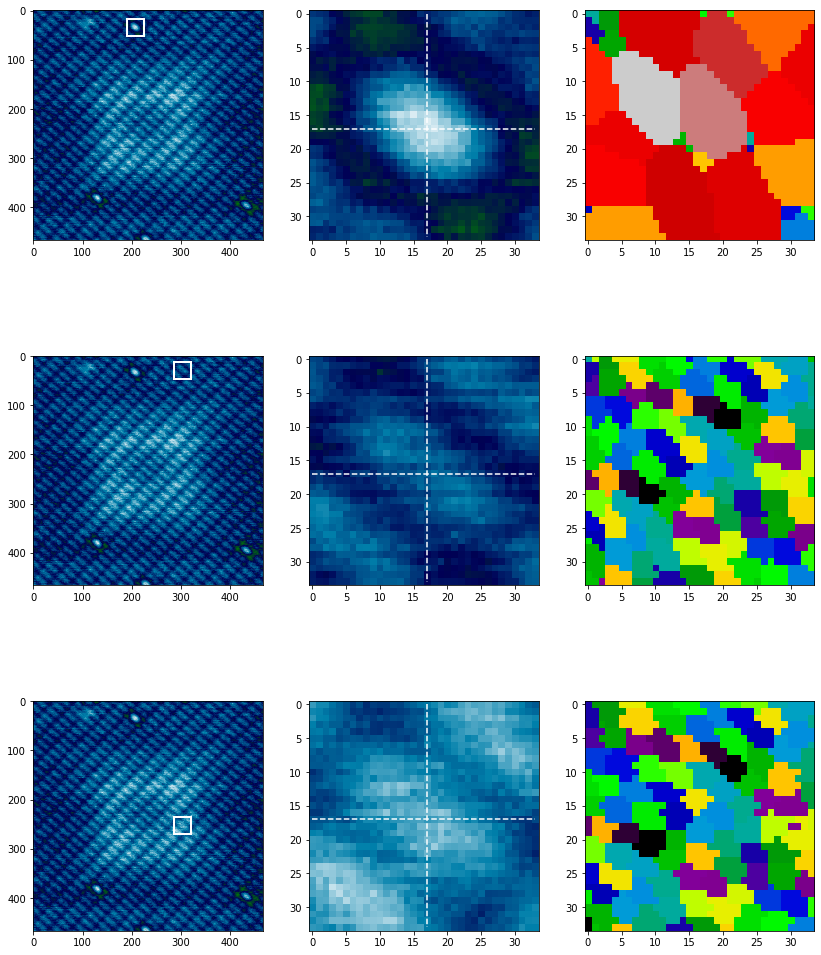

In [70]:
# Duplicate imgNp with a full window border cropped on all sides
fullCroppedImage = croppedImg[halfWindow:-halfWindow, halfWindow:-halfWindow]

# create figure to display all the motifs chosen
numMotifs = len(motifWinCenters)
figSM, axesSM = plt.subplots(ncols=3, nrows=numMotifs, figsize=(14,6 * numMotifs))

# Initialise a list for motif images
motifs = list()

for window_center, ax_row in zip(motifWinCenters, np.atleast_2d(axesSM)):
    indices = (slice(window_center[0] - halfWindow, window_center[0] + halfWindow), 
               slice(window_center[1] - halfWindow, window_center[1] + halfWindow))
    motifs.append(labelsMat[indices])
    
    ax_row[0].clear()
    ax_row[0].imshow(croppedImg, interpolation='none',cmap=imageCmap)
    ax_row[0].add_patch(patches.Rectangle((window_center[1] - int(0.5*motifWinSize), 
                                           window_center[0] - int(0.5*motifWinSize)),
                                          motifWinSize, motifWinSize, fill=False,
                                         color='w', linewidth=2))

    ax_row[1].clear()
    ax_row[1].imshow(croppedImg[indices], interpolation='none',cmap=imageCmap,
                     vmax=np.max(croppedImg), vmin=np.min(croppedImg))
    ax_row[1].plot([0, motifWinSize-2],[int(0.5*motifWinSize), int(0.5*motifWinSize)], 'w--')
    ax_row[1].plot([int(0.5*motifWinSize), int(0.5*motifWinSize)], [0, motifWinSize-2], 'w--')
   
    ax_row[2].imshow(labelsMat[indices], interpolation='none',cmap=labelsCmap,
                     vmax=numKMClusters-1, vmin=0)
   

In [71]:
# Initiallise list
motifMatchCoeffs = list()

for motifMat in motifs:
    
    matchMat = np.zeros(shape=(numWindowRows-motifWinSize, numWindowCols-motifWinSize))
    for rowCount, rowPos in enumerate(range(halfWindow, numWindowRows - halfWindow - 1, 1)):
        for colCount, colPos in enumerate(range(halfWindow, numWindowCols - halfWindow - 1, 1)):
            localClusterMat = labelsMat[rowPos-halfWindow : rowPos+halfWindow, 
                                           colPos-halfWindow : colPos+halfWindow]
            matchMat[rowCount, colCount] = np.sum(localClusterMat == motifMat)
    
    # Normalize 
    matchMat = matchMat/np.max(matchMat)
    
    # Append to list
    motifMatchCoeffs.append(matchMat)

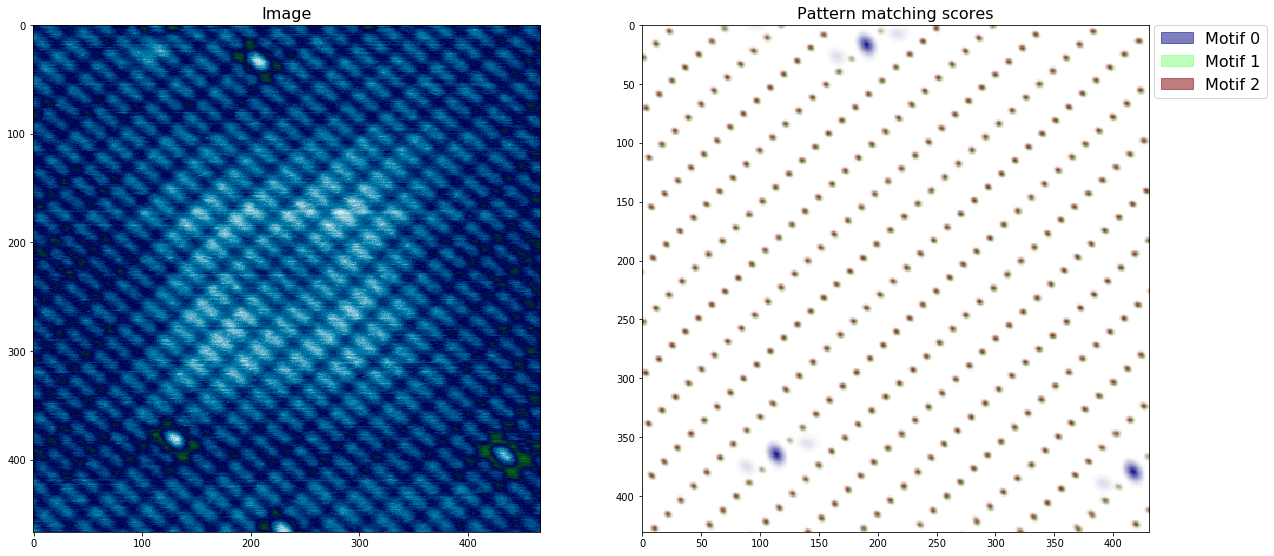

In [72]:
# Dispaly motifMatchCoeffs

# Make a plot window
figMotif, axesMotif = plt.subplots(ncols=2,figsize=(20,10))

_ = axesMotif[0].clear()
_ = axesMotif[0].imshow(croppedImg,cmap=imageCmap,clim=colorBarLim)
_ = axesMotif[0].set_title('Image', fontsize=16)

imMotif = axesMotif[1].imshow(fullCroppedImage, cmap="gray")
_ = axesMotif[1].clear() # removes the image - can comment this out if you prefer to see it

# Create colors for motif maps
baseColorMap = plt.cm.jet
if numMotifs > 1:
    motifColors = [baseColorMap(int(255 * motif_ind / (numMotifs - 1))) for motif_ind in range(numMotifs)]
else:
    motifColors = [baseColorMap[0]]
  
# Initialise list
handles = list()

# Plot motif maps
for motifInd, currentSolidColor, matchMat in zip(range(numMotifs), motifColors, motifMatchCoeffs):
    myCmap = usid.viz.plot_utils.cmap.make_linear_alpha_cmap('fdfd', currentSolidColor, 1)
    im = plt.imshow(matchMat, cmap=myCmap);
    currentSolidColor = list(currentSolidColor)
    currentSolidColor[3] = 0.5 # maximum alpha value
    handles.append(patches.Patch(color=currentSolidColor, label='Motif {}'.format(motifInd)))
    

_ = axesMotif[1].set_title('Pattern matching scores', fontsize=16)
_ = axesMotif[1].legend(handles=handles, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=16)


